# Gap-fill meteo variables

</br>

# Settings

## Data settings

In [1]:
SITE_LAT = 47.478333   # CH-LAE
SITE_LON = 8.364389  # CH-LAE
TIMEZONE_OFFSET_TO_UTC_HOURS = 1  # Timezone, e.g. "1" is translated to timezone "UTC+01:00" (CET, winter time)

## Imports

In [2]:
from datetime import datetime
import importlib.metadata
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
sns.set_theme('notebook')
from diive.core.plotting.timeseries import TimeSeries
from diive.core.io.files import load_parquet, save_parquet
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.core.times.times import DetectFrequency
from diive.core.times.times import TimestampSanitizer
from diive.pkgs.createvar.potentialradiation import potrad
from diive.pkgs.gapfilling.xgboost_ts import XGBoostTS
from diive.pkgs.corrections.offsetcorrection import remove_relativehumidity_offset, remove_radiation_zero_offset
import warnings
from influxdb_client.client.warnings import MissingPivotFunction
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.87.1


</br>

# Load data from files

In [3]:
filename_data_simple_2004_2024 = "12.1_METEO6_NOT-GAPFILLED_2004-2024.parquet"
data_simple_2004_2024 = load_parquet(filepath=filename_data_simple_2004_2024)
data_simple_2004_2024

Loaded .parquet file 12.1_METEO6_NOT-GAPFILLED_2004-2024.parquet (0.071 seconds).
    --> Detected time resolution of <30 * Minutes> / 30min 


,LW_IN_T1_47_1,PA_T1_47_1,PPFD_IN_T1_47_1,RH_T1_47_1,SW_IN_T1_47_1,TA_T1_47_1
TIMESTAMP_MIDDLE,,,,,,
2004-09-20 10:45:00,NaN,NaN,1070.543364,80.503701,NaN,13.300000
2004-09-20 11:15:00,NaN,NaN,881.543364,77.503701,NaN,13.390000
2004-09-20 11:45:00,NaN,NaN,1022.543364,75.803704,NaN,13.810000
2004-09-20 12:15:00,NaN,NaN,1284.543364,71.503701,NaN,14.470000
2004-09-20 12:45:00,NaN,NaN,742.543364,72.703705,NaN,13.980000
...,...,...,...,...,...,...
2024-12-31 21:45:00,232.595527,94.211806,0.000000,87.254008,0.0,-0.504794
2024-12-31 22:15:00,232.609777,94.189013,0.000000,87.430236,0.0,-0.296828
2024-12-31 22:45:00,232.345020,94.169525,0.000000,89.787920,0.0,-0.392922


</br>

# Gap-filling

## SW_IN_T1_47_1

In [4]:
VAR = "SW_IN_T1_47_1"

In [5]:
_df = pd.DataFrame()
_df[VAR] = data_simple_2004_2024[[VAR]].copy()
_df['SW_IN_POT'] = potrad(timestamp_index=_df.index, lat=SITE_LAT, lon=SITE_LON, utc_offset=1)
_df

,SW_IN_T1_47_1,SW_IN_POT
TIMESTAMP_MIDDLE,,
2004-09-20 10:45:00,NaN,833.243912
2004-09-20 11:15:00,NaN,877.607230
2004-09-20 11:45:00,NaN,906.992208
2004-09-20 12:15:00,NaN,920.896059
2004-09-20 12:45:00,NaN,919.080885
...,...,...
2024-12-31 21:45:00,0.0,0.000000
2024-12-31 22:15:00,0.0,0.000000
2024-12-31 22:45:00,0.0,0.000000


In [6]:
xgb = XGBoostTS(
    input_df=_df,
    target_col=VAR,
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=1000,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)


Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 355563.


In [7]:
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()


Training final model ...
>>> Training model <class 'xgboost.sklearn.XGBRegressor'> based on data between 2004-09-20 18:45:00 and 2024-12-31 23:45:00 ...
>>> Fitting model to training data ...
[0]	validation_0-rmse:187.20808	validation_1-rmse:187.23916
[1]	validation_0-rmse:156.90019	validation_1-rmse:157.08066
[2]	validation_0-rmse:139.51174	validation_1-rmse:139.72723
[3]	validation_0-rmse:129.93945	validation_1-rmse:130.18473
[4]	validation_0-rmse:124.76174	validation_1-rmse:125.02259
[5]	validation_0-rmse:122.02444	validation_1-rmse:122.32108
[6]	validation_0-rmse:120.37094	validation_1-rmse:120.69973
[7]	validation_0-rmse:119.33020	validation_1-rmse:119.67993
[8]	validation_0-rmse:118.58894	validation_1-rmse:118.95800
[9]	validation_0-rmse:118.02906	validation_1-rmse:118.41308
[10]	validation_0-rmse:117.55467	validation_1-rmse:117.97495
[11]	validation_0-rmse:116.96120	validation_1-rmse:117.40361
[12]	validation_0-rmse:116.62434	validation_1-rmse:117.08419
[13]	validation_0-rmse:1

In [8]:
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()


Gap-filling using final model ...
>>> Using final model on all data to predict target SW_IN_T1_47_1 ...
>>> Using final model on all data to calculate permutation importance ...
>>> Calculating prediction scores based on all data predicting SW_IN_T1_47_1 ...
>>> Predicting target SW_IN_T1_47_1 where all features are available ... predicted 355563 records.
>>> Collecting results for final model ...
>>> Filling 9939 missing records in target with predictions from final model ...
>>> Storing gap-filled time series in variable SW_IN_T1_47_1_gfXG ...
>>> Restoring original timestamp in results ...

Gap-filling 0 remaining missing records in SW_IN_T1_47_1_gfXG using fallback model ...
>>> Fallback model not necessary, all gaps were already filled.
>>> Combining predictions from full model and fallback model ...

GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (9939 values, SW_IN_T1_47_1_gfXG where flag=1) in comparison to observe

In [9]:
observed = _df[VAR]
gapfilled = xgb.get_gapfilled_target()
data_simple_2004_2024[gapfilled.name] = gapfilled

# TODO: SECOND GAPFILLING USING PPFD (more complete)

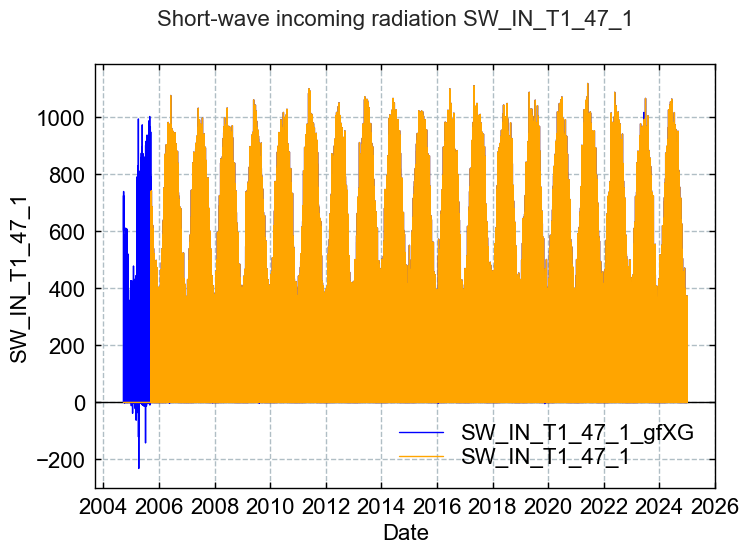

In [10]:
title=f"Short-wave incoming radiation {VAR}"
fig, ax = plt.subplots()
TimeSeries(series=gapfilled, ax=ax).plot(color='blue')
TimeSeries(series=observed, ax=ax).plot(color='orange')
fig.suptitle(f'{title}', fontsize=16)
# ax.set_ylim(-2000, 200)
fig.show()

### Correction: Remove zero offset < 0 from `SW_IN_T1_47_1_gfXG`
- Additional correction needed because gap-filling introduced values < 0

[remove_radiation_zero_offset]  running remove_radiation_zero_offset ...


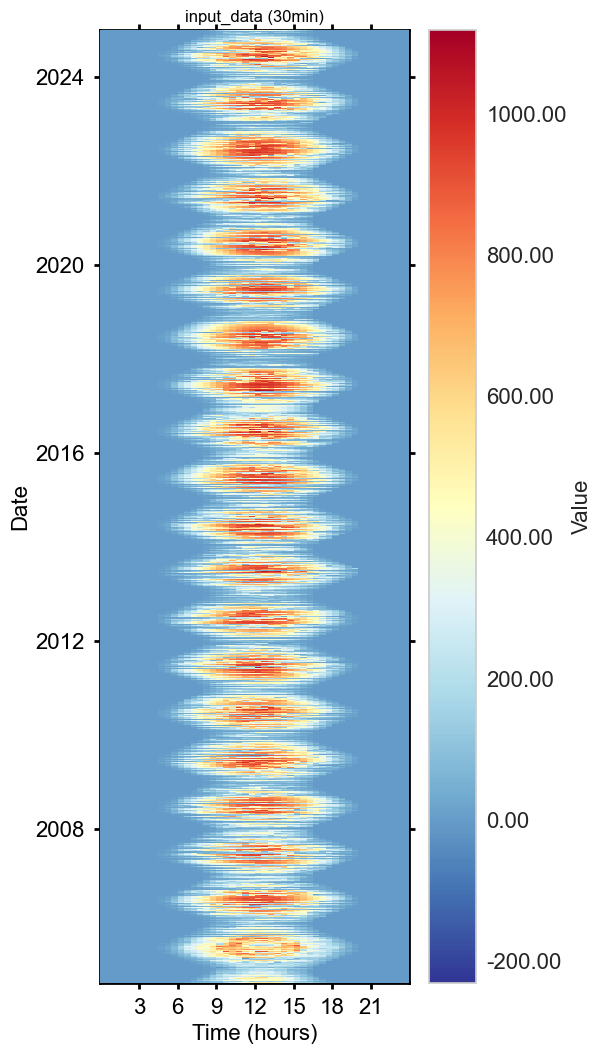

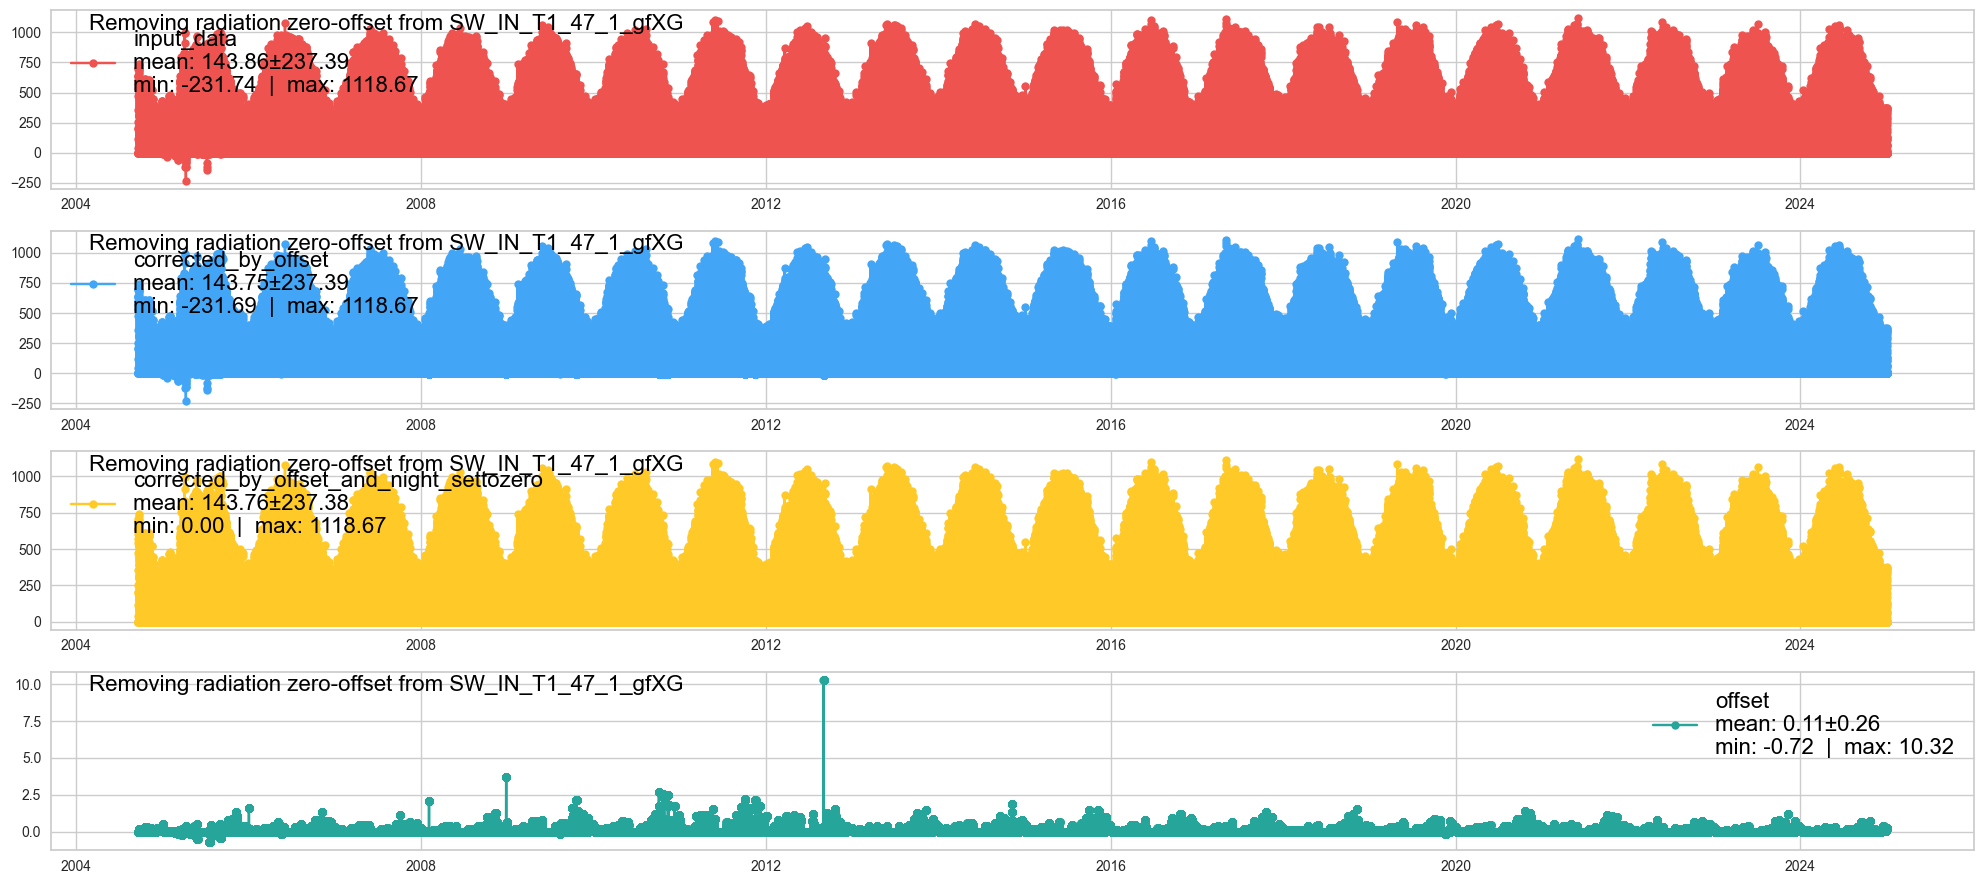

In [11]:
_swin = data_simple_2004_2024['SW_IN_T1_47_1_gfXG'].copy()
_swin_corrected = remove_radiation_zero_offset(series=_swin, lat=SITE_LAT, lon=SITE_LON, utc_offset=1, showplot=True)
data_simple_2004_2024['SW_IN_T1_47_1_gfXG'] = np.nan
data_simple_2004_2024['SW_IN_T1_47_1_gfXG'] = _swin_corrected

## TA_T1_47_1

In [13]:
VAR = "TA_T1_47_1"

In [14]:
_df = pd.DataFrame()
_df['SW_IN_T1_47_1_gfXG'] = data_simple_2004_2024['SW_IN_T1_47_1_gfXG'].copy()
_df[VAR] = data_simple_2004_2024[VAR].copy()
_df['SW_IN_POT'] = potrad(timestamp_index=_df.index, lat=SITE_LAT, lon=SITE_LON, utc_offset=1)
_df

,SW_IN_T1_47_1_gfXG,TA_T1_47_1,SW_IN_POT
TIMESTAMP_MIDDLE,,,
2004-09-20 10:45:00,602.874084,13.300000,833.243912
2004-09-20 11:15:00,703.762207,13.390000,877.607230
2004-09-20 11:45:00,537.947327,13.810000,906.992208
2004-09-20 12:15:00,634.747437,14.470000,920.896059
2004-09-20 12:45:00,634.747437,13.980000,919.080885
...,...,...,...
2024-12-31 21:45:00,0.000000,-0.504794,0.000000
2024-12-31 22:15:00,0.000000,-0.296828,0.000000
2024-12-31 22:45:00,0.000000,-0.392922,0.000000


In [15]:
xgb = XGBoostTS(
    input_df=_df,
    target_col=VAR,
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=1000,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)


Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 355563.


In [16]:
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()


Training final model ...
>>> Training model <class 'xgboost.sklearn.XGBRegressor'> based on data between 2004-09-20 11:15:00 and 2024-12-31 23:15:00 ...
>>> Fitting model to training data ...
[0]	validation_0-rmse:6.51439	validation_1-rmse:6.50729
[1]	validation_0-rmse:5.44212	validation_1-rmse:5.43619
[2]	validation_0-rmse:4.78323	validation_1-rmse:4.77965
[3]	validation_0-rmse:4.38358	validation_1-rmse:4.38169
[4]	validation_0-rmse:4.12475	validation_1-rmse:4.12273
[5]	validation_0-rmse:3.97601	validation_1-rmse:3.97627
[6]	validation_0-rmse:3.88080	validation_1-rmse:3.88344
[7]	validation_0-rmse:3.77624	validation_1-rmse:3.78136
[8]	validation_0-rmse:3.72931	validation_1-rmse:3.73688
[9]	validation_0-rmse:3.66637	validation_1-rmse:3.67507
[10]	validation_0-rmse:3.64036	validation_1-rmse:3.65014
[11]	validation_0-rmse:3.61965	validation_1-rmse:3.62953
[12]	validation_0-rmse:3.59049	validation_1-rmse:3.60058
[13]	validation_0-rmse:3.55664	validation_1-rmse:3.56586
[14]	validation_0-r

In [17]:
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()


Gap-filling using final model ...
>>> Using final model on all data to predict target TA_T1_47_1 ...
>>> Using final model on all data to calculate permutation importance ...
>>> Calculating prediction scores based on all data predicting TA_T1_47_1 ...
>>> Predicting target TA_T1_47_1 where all features are available ... predicted 355563 records.
>>> Collecting results for final model ...
>>> Filling 2803 missing records in target with predictions from final model ...
>>> Storing gap-filled time series in variable TA_T1_47_1_gfXG ...
>>> Restoring original timestamp in results ...

Gap-filling 0 remaining missing records in TA_T1_47_1_gfXG using fallback model ...
>>> Fallback model not necessary, all gaps were already filled.
>>> Combining predictions from full model and fallback model ...

GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (2803 values, TA_T1_47_1_gfXG where flag=1) in comparison to observed targets (352760 

In [18]:
observed = _df[VAR]
gapfilled = xgb.get_gapfilled_target()
data_simple_2004_2024[gapfilled.name] = gapfilled

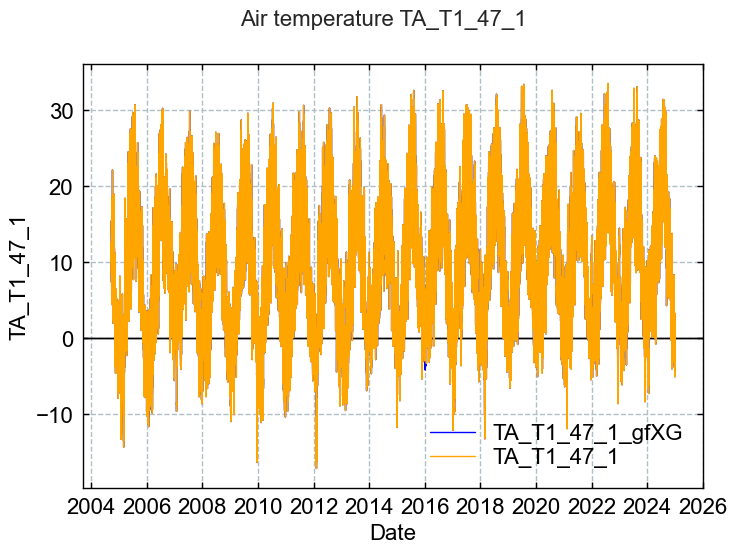

In [19]:
title=f"Air temperature {VAR}"
fig, ax = plt.subplots()
TimeSeries(series=gapfilled, ax=ax).plot(color='blue')
TimeSeries(series=observed, ax=ax).plot(color='orange')
fig.suptitle(f'{title}', fontsize=16)
# ax.set_ylim(-2000, 200)
fig.show()

## PPFD_IN_T1_47_1

In [20]:
VAR = "PPFD_IN_T1_47_1"

In [21]:
_df = pd.DataFrame()
_df[VAR] = data_simple_2004_2024[[VAR]].copy()
_df['SW_IN_T1_47_1_gfXG'] = data_simple_2004_2024[['SW_IN_T1_47_1_gfXG']].copy()
_df['SW_IN_POT'] = potrad(timestamp_index=_df.index, lat=SITE_LAT, lon=SITE_LON, utc_offset=1)
_df

,PPFD_IN_T1_47_1,SW_IN_T1_47_1_gfXG,SW_IN_POT
TIMESTAMP_MIDDLE,,,
2004-09-20 10:45:00,1070.543364,602.874084,833.243912
2004-09-20 11:15:00,881.543364,703.762207,877.607230
2004-09-20 11:45:00,1022.543364,537.947327,906.992208
2004-09-20 12:15:00,1284.543364,634.747437,920.896059
2004-09-20 12:45:00,742.543364,634.747437,919.080885
...,...,...,...
2024-12-31 21:45:00,0.000000,0.000000,0.000000
2024-12-31 22:15:00,0.000000,0.000000,0.000000
2024-12-31 22:45:00,0.000000,0.000000,0.000000


In [22]:
xgb = XGBoostTS(
    input_df=_df,
    target_col=VAR,
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=1000,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)


Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 355563.


In [23]:
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()


Training final model ...
>>> Training model <class 'xgboost.sklearn.XGBRegressor'> based on data between 2004-09-20 11:15:00 and 2024-12-31 23:45:00 ...
>>> Fitting model to training data ...
[0]	validation_0-rmse:345.02626	validation_1-rmse:344.00697
[1]	validation_0-rmse:246.73296	validation_1-rmse:246.29028
[2]	validation_0-rmse:179.59376	validation_1-rmse:179.74638
[3]	validation_0-rmse:134.65078	validation_1-rmse:135.46387
[4]	validation_0-rmse:105.47418	validation_1-rmse:106.77603
[5]	validation_0-rmse:87.35770	validation_1-rmse:89.15519
[6]	validation_0-rmse:76.08535	validation_1-rmse:78.44043
[7]	validation_0-rmse:69.66377	validation_1-rmse:72.43137
[8]	validation_0-rmse:65.70490	validation_1-rmse:68.62900
[9]	validation_0-rmse:63.02954	validation_1-rmse:66.05020
[10]	validation_0-rmse:61.06255	validation_1-rmse:64.20536
[11]	validation_0-rmse:59.74582	validation_1-rmse:63.01348
[12]	validation_0-rmse:58.47759	validation_1-rmse:62.10080
[13]	validation_0-rmse:57.21922	validati

In [24]:
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()


Gap-filling using final model ...
>>> Using final model on all data to predict target PPFD_IN_T1_47_1 ...
>>> Using final model on all data to calculate permutation importance ...
>>> Calculating prediction scores based on all data predicting PPFD_IN_T1_47_1 ...
>>> Predicting target PPFD_IN_T1_47_1 where all features are available ... predicted 355563 records.
>>> Collecting results for final model ...
>>> Filling 1282 missing records in target with predictions from final model ...
>>> Storing gap-filled time series in variable PPFD_IN_T1_47_1_gfXG ...
>>> Restoring original timestamp in results ...

Gap-filling 0 remaining missing records in PPFD_IN_T1_47_1_gfXG using fallback model ...
>>> Fallback model not necessary, all gaps were already filled.
>>> Combining predictions from full model and fallback model ...

GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (1282 values, PPFD_IN_T1_47_1_gfXG where flag=1) in compariso

In [25]:
observed = _df[VAR]
gapfilled = xgb.get_gapfilled_target()
data_simple_2004_2024[gapfilled.name] = gapfilled

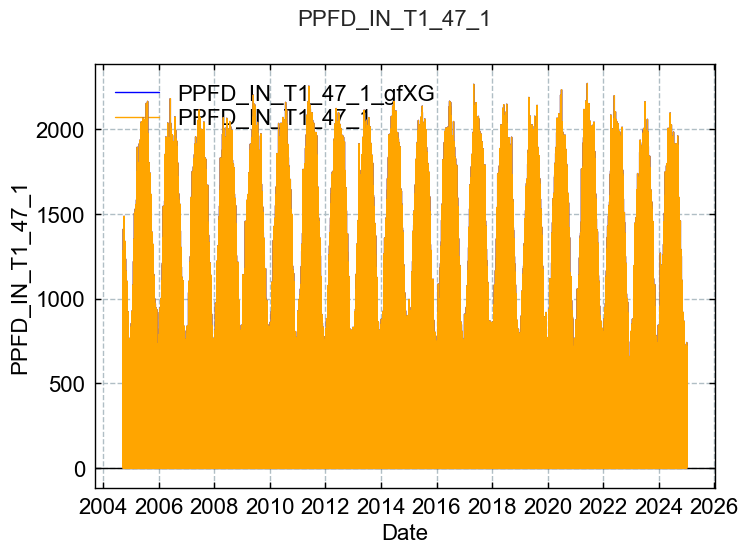

In [26]:
title=f"{VAR}"
fig, ax = plt.subplots()
TimeSeries(series=gapfilled, ax=ax).plot(color='blue')
TimeSeries(series=observed, ax=ax).plot(color='orange')
fig.suptitle(f'{title}', fontsize=16)
# ax.set_ylim(-2000, 200)
fig.show()

</br>

# Plots

In [27]:
_plot_df = data_simple_2004_2024.copy()
_plot_df = _plot_df.replace(-9999, np.nan)

## Time series plot

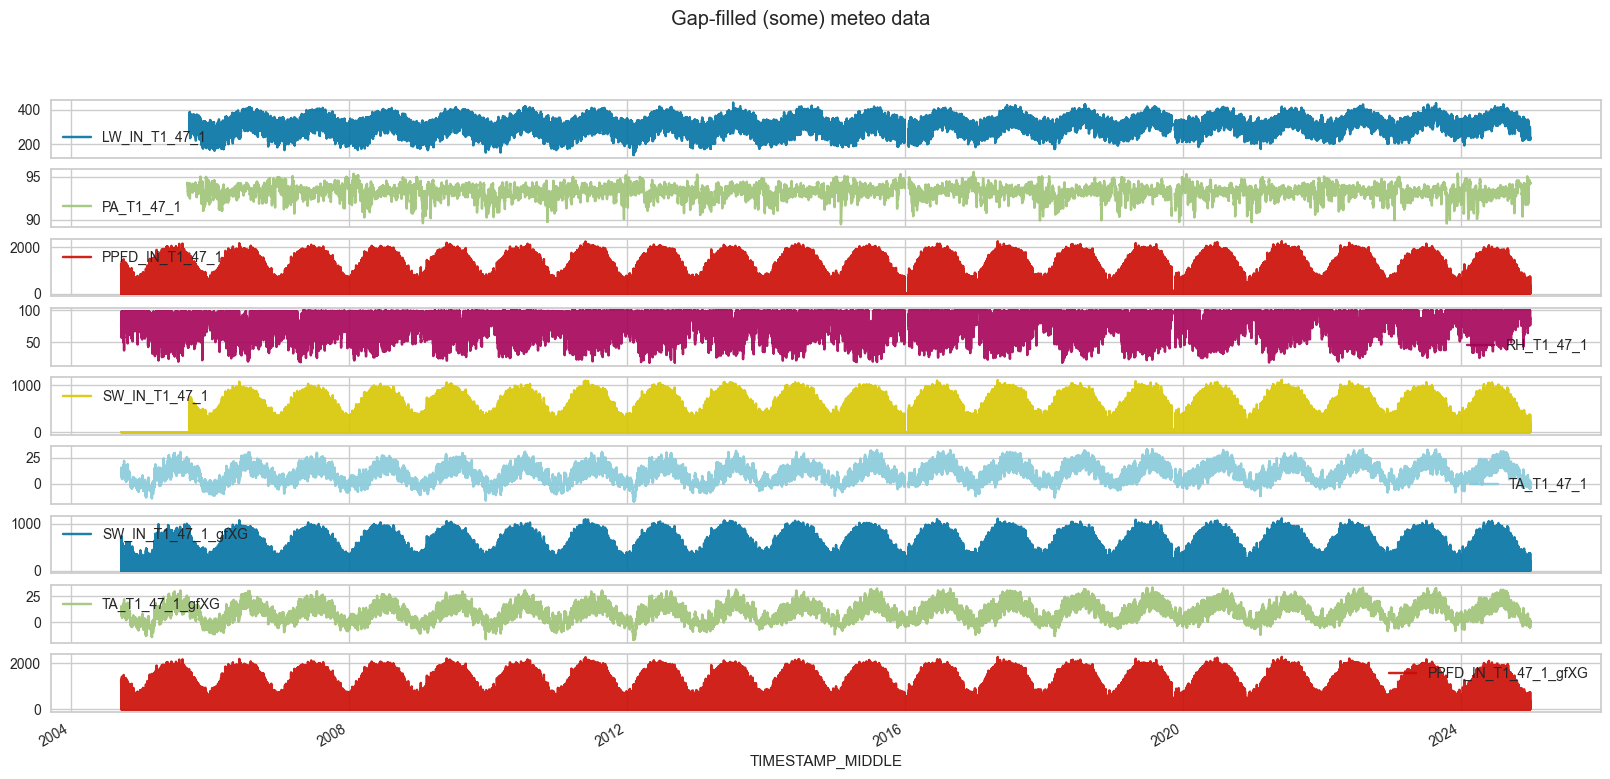

In [28]:
_plot_df.plot(subplots=True, figsize=(20, 9), title="Gap-filled (some) meteo data", alpha=.9, x_compat=True);

## Heatmaps

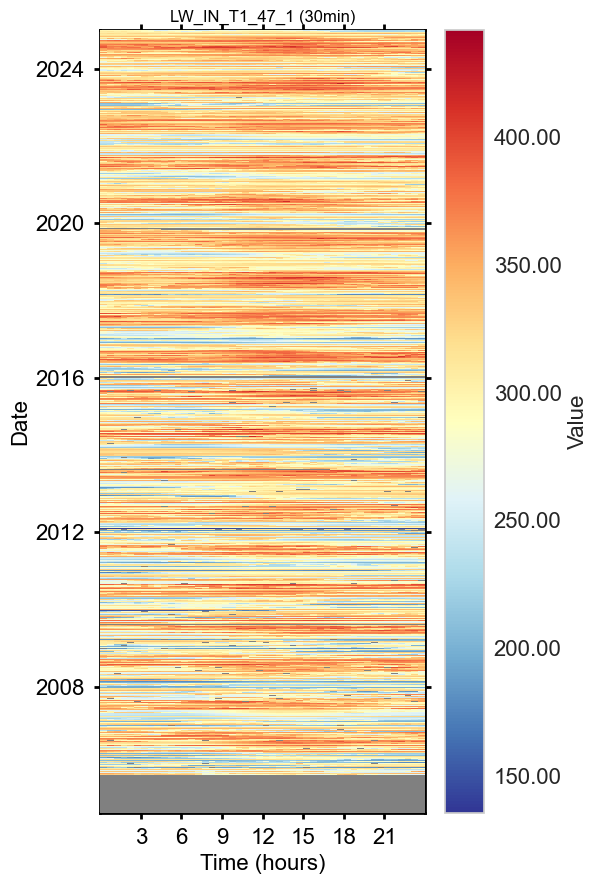

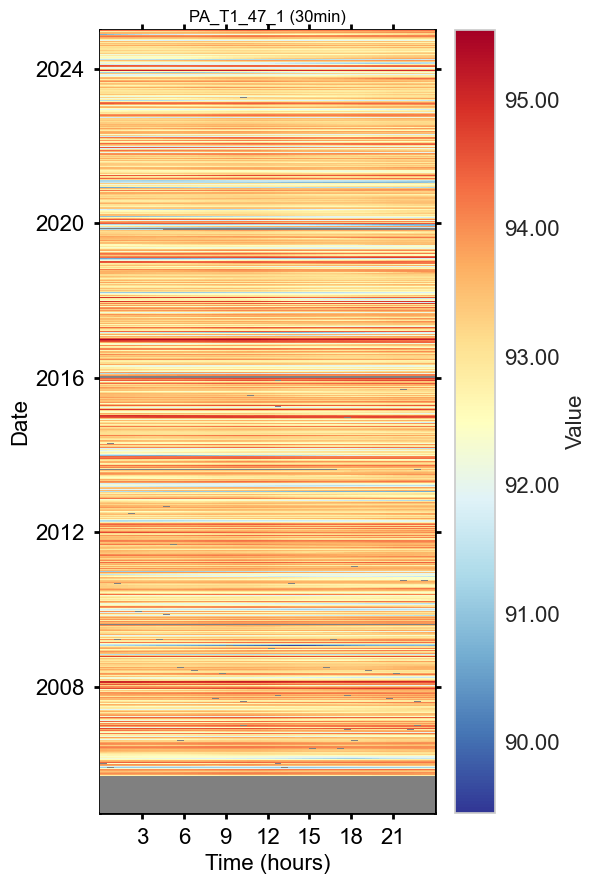

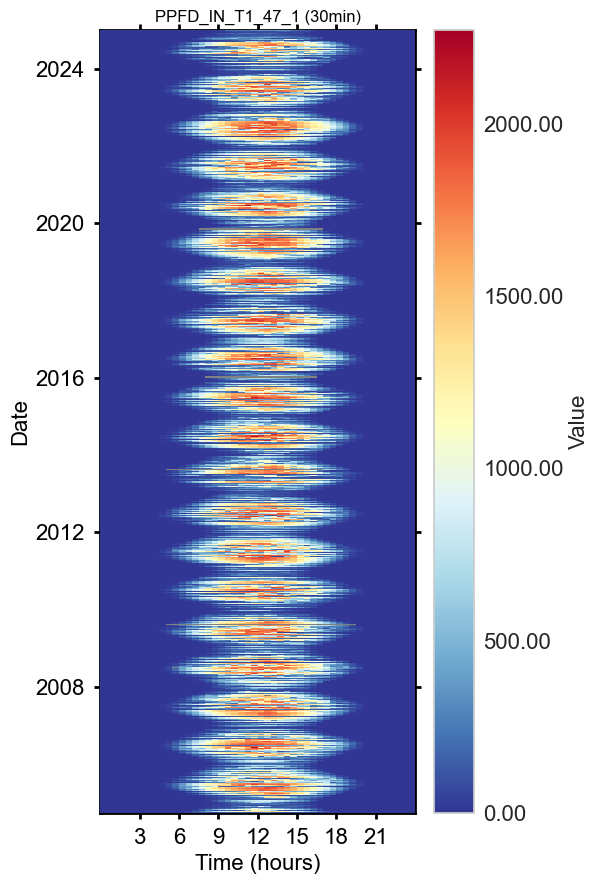

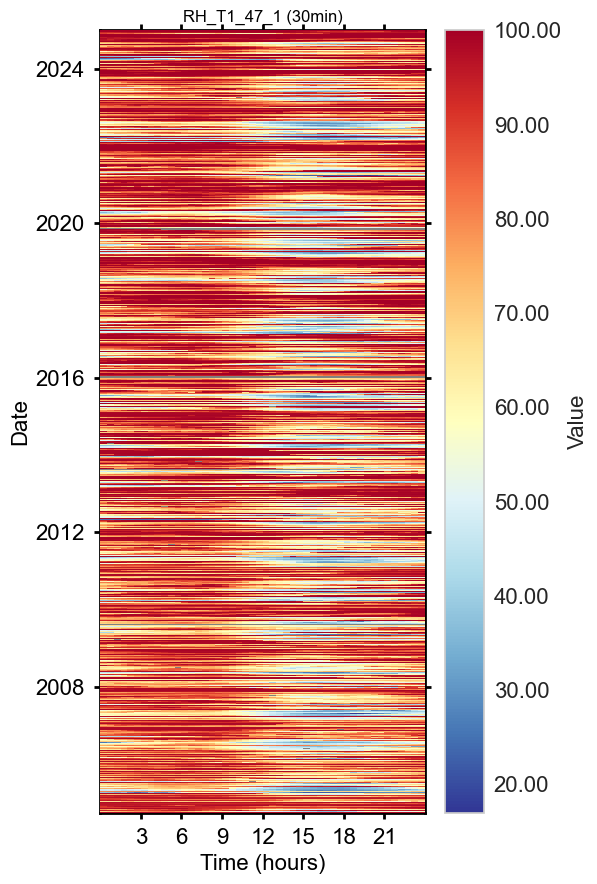

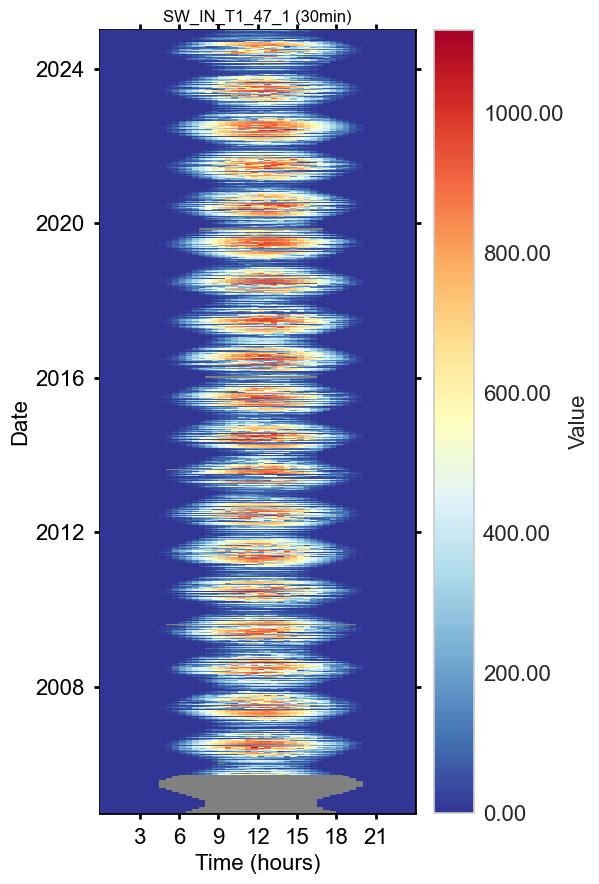

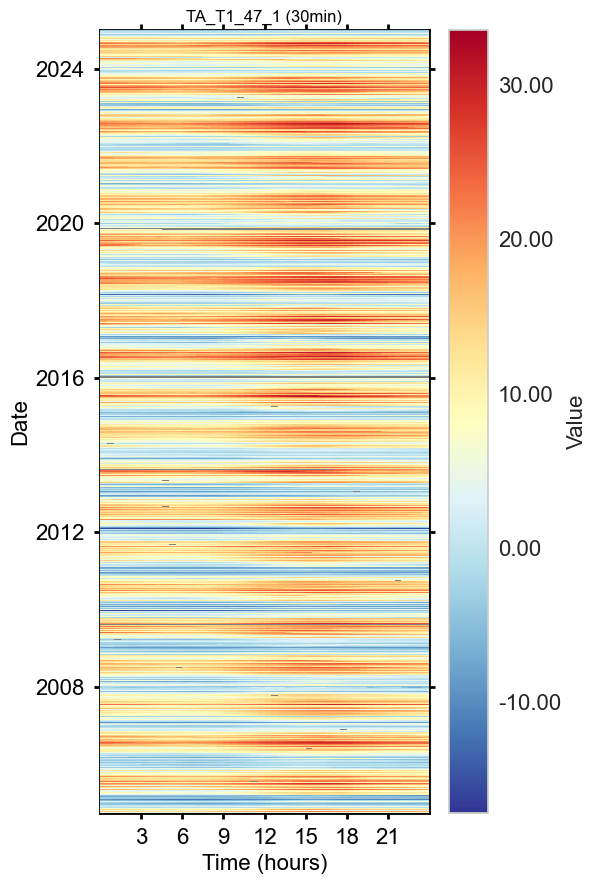

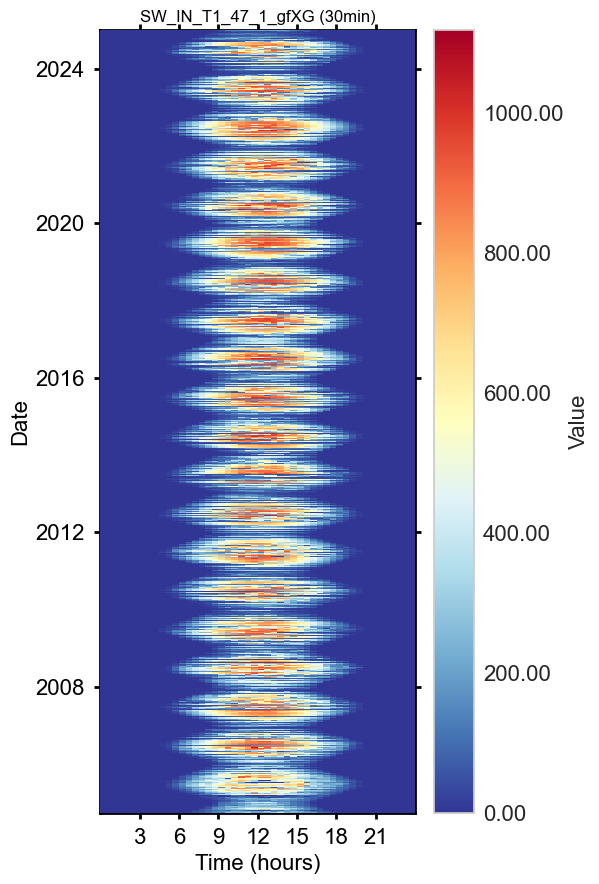

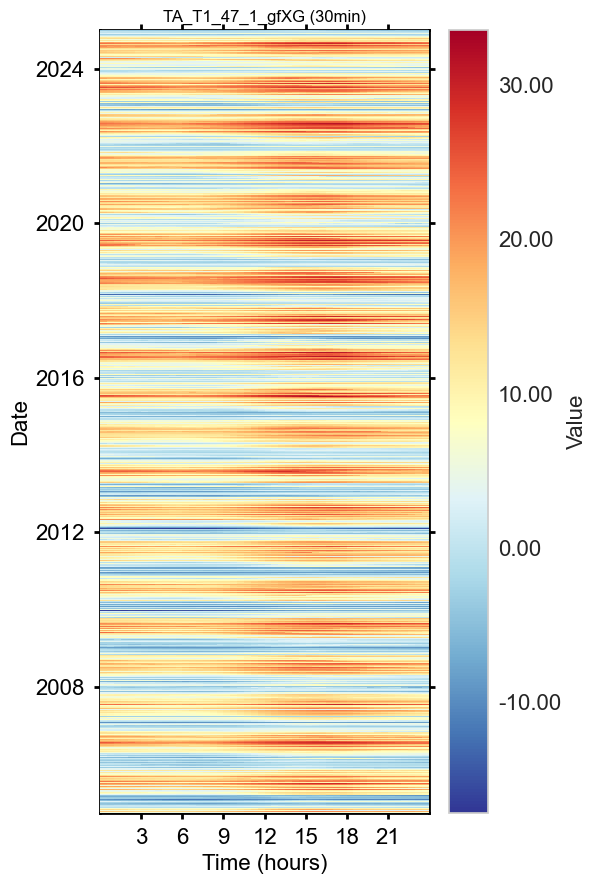

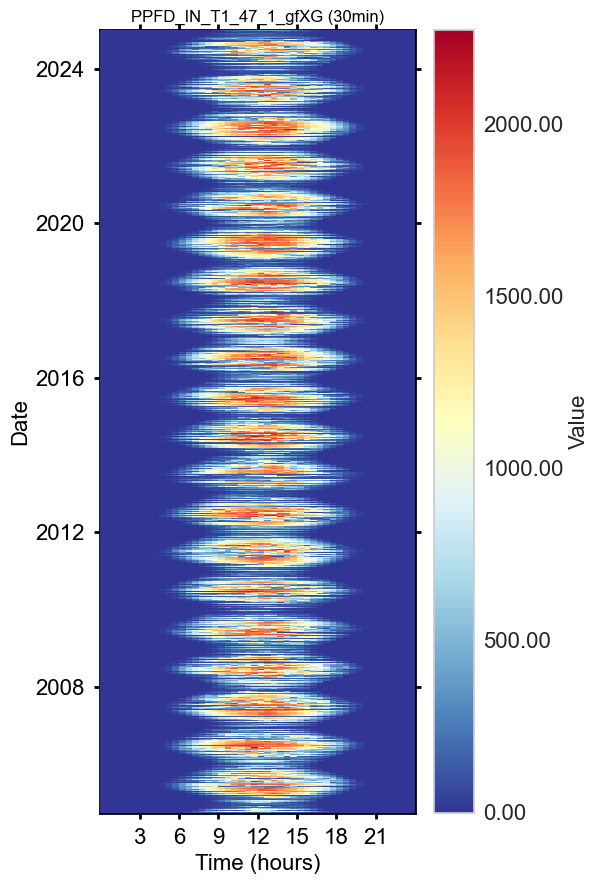

In [29]:
for col in _plot_df.columns:    
    series = _plot_df[col]
    series.name = col
    HeatmapDateTime(series, figsize=(6,9)).show()    

</br>

# Stats

In [30]:
data_simple_2004_2024.describe()

,LW_IN_T1_47_1,PA_T1_47_1,PPFD_IN_T1_47_1,RH_T1_47_1,SW_IN_T1_47_1,TA_T1_47_1,SW_IN_T1_47_1_gfXG,TA_T1_47_1_gfXG,PPFD_IN_T1_47_1_gfXG
count,334651.000000,335887.000000,354281.000000,352774.000000,345624.000000,352760.000000,355563.000000,355563.000000,355563.000000
mean,310.191939,93.234546,288.553030,79.283494,140.243968,8.898763,143.758864,8.890540,289.405280
std,45.718410,0.743782,486.866078,18.817820,237.022077,8.170412,237.382005,8.173191,487.050354
min,135.445129,89.446007,0.000000,16.934985,0.000000,-17.200001,0.000000,-17.200001,-2.392997
25%,282.017899,92.851006,0.000000,65.473702,0.000000,2.581000,0.000000,2.560453,0.000000
50%,315.560983,93.309998,0.000000,82.847867,0.000000,8.822186,0.000000,8.790000,0.000000
75%,343.077050,93.703298,369.686569,98.043015,182.744032,14.940000,196.250065,14.947231,372.034233
max,441.779694,95.543335,2270.612673,100.000000,1118.665920,33.558765,1118.665920,33.558765,2270.612673


</br>

# Save to file

In [31]:
OUTNAME = "12.3_METEO6_GAPFILLED_2004-2024"
OUTPATH = r""
filepath = save_parquet(filename=OUTNAME, data=data_simple_2004_2024, outpath=OUTPATH)
data_simple_2004_2024.to_csv(Path(OUTPATH) / f"{OUTNAME}.csv")

Saved file 12.3_METEO6_GAPFILLED_2004-2024.parquet (0.190 seconds).


</br>

# End of notebook.

In [32]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2025-06-12 00:37:47


</br>